In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import palettable
import seaborn as sns

In [2]:
device = torch.device("cpu" if torch.cuda.device_count() != 0 else "cpu")
print(device)

n_qubits = 50
n_outcomes =4
batchSize =200
hidden_size = 100
num_gru_layers = 2
num_epochs = 50
log_interval = 50
loss_by_step = True
lr = 0.001

cpu


In [3]:
data_array = np.load('data/TFIM_training_data.npz')['data']
log_probs = np.load('data/TFIM_logprobs.npz')['probs']
#print(data_array.shape)

In [4]:
reshaped_array = np.empty((data_array.shape[0], 50))
for i in range(data_array.shape[0]):
    data = data_array[i].reshape((50,4))
    onetoind = [np.where(r==1)[0][0] for r in data]
    reshaped_array[i] = onetoind
    #break
    
print(reshaped_array[0].shape)

(50,)


In [5]:
print(reshaped_array[0])
print(data_array[0])

[0. 3. 3. 2. 3. 3. 3. 3. 3. 1. 1. 3. 3. 3. 3. 3. 2. 0. 3. 3. 2. 2. 3. 3.
 2. 3. 3. 3. 3. 3. 0. 3. 2. 2. 2. 0. 1. 1. 3. 3. 3. 0. 1. 3. 2. 0. 2. 3.
 3. 3.]
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1.]


In [31]:
# I LOAD THE DATA INTO A PYTORCH DATALOADER CLASS

tensor_array_train = torch.stack([torch.Tensor(i).double() for i in reshaped_array[:10000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train)
tensor_array_test = torch.stack([torch.Tensor(i).double() for i in reshaped_array[10000:20000]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=1)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 1)
print(train_loader)

In [26]:
class QubitRNN(nn.Module):
    def __init__(self, n_outcomes, hidden_size, output_size):
        super(QubitRNN, self).__init__()
        self.n_outcomes = n_outcomes
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder = nn.Embedding(n_outcomes, n_outcomes)
        self.rnn = nn.GRU(n_outcomes, hidden_size, 1)
        self.decoder = nn.Linear(hidden_size, n_outcomes)

    def forward(self, input, hidden):
        
        # input first dimension is batch, second is 1
        batch_size = input.size(0)
        encoded = self.encoder(input).float()
        #print(encoded.shape)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

#     def forward2(self, input, hidden):
#         encoded = self.encoder(input.view(1, -1))
#         output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
#         output = self.decoder(output.view(1, -1))
#         return output, hidden

    def initHidden(self, batchSize):
        
        '''
        must be shape 
        [self.num_layers * num_directions (1 in this case), batchSize, hidden_size]
        '''
        return torch.zeros(1, batchSize, self.hidden_size).to(device).float()
    
    def initX(self, batchSize):
        '''
        must be shape 
        [(1 step), batchSize, hidden_size]
        '''
        return torch.zeros(batchSize).to(device).double()

In [36]:
rnn = QubitRNN(n_outcomes, hidden_size, n_outcomes)
optimizer = optim.Adam(rnn.parameters(), lr=lr)

criterion = torch.nn.CrossEntropyLoss()
for epoch in range(1, num_epochs + 1):
    #train(epoch, train_losses)
    train_loss = 0
    for batch_idx, (data) in enumerate(train_loader,):
        optimizer.zero_grad()
        data = data[0].to(device).float()#.permute(1,0,2)#.reshape(n_qubits, batchSize, n_outcomes)
        #print(data.shape)
        hidden = rnn.initHidden(batchSize).to(device)
        inp0 = rnn.initX(batchSize).to(device)
        rnn.zero_grad()
        loss = 0
        for c in range(n_qubits):
            if c == 0:
                #print(inp0.long().shape)
                #print(data[:,c].shape)
                output, hidden = rnn(inp0.long(), hidden)
            else:
                output, hidden = rnn(data[:,c-1].long(), hidden)
            loss += criterion(output.view(batchSize, -1), data[:,c].long())
            loss.backward(retain_graph = False)
            optimizer.step()
            optimizer.zero_grad()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batchSize, len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / batchSize))
        
        
        


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [18]:
def generate(rnn, batch_size = batchSize,predict_len=n_qubits, cuda=True):
    hidden = rnn.initHidden(batch_size).to(device)
    inp = rnn.initX(batch_size).to(device)

    tot_output = torch.zeros(batch_size,50)
    for p in range(n_qubits):
        output, hidden = rnn(inp.long(), hidden)
        #print(output.shape, hidden.shape)
        # Sample from the network as a multinomial distribution
       # print(output.shape,hidden.shape)
        output_dist = F.softmax(output.data,dim=1)#.div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)
        #print(top_i.shape)
        
        tot_output[:,p] = top_i[:,0]

        # Add predicted character to string and use as next input
        #predicted_char = all_characters[top_i]
        #predicted += predicted_char
        #inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        #if cuda:
        #    inp = inp.cuda()
        inp = top_i

    return tot_output

In [19]:
samples = generate(rnn, batch_size = 10000)
from itertools import groupby
output_list = samples.view(-1).int().cpu().data.numpy()
sorted_list = list(np.sort(output_list))
counts = [len(list(group)) for key, group in 
         groupby(sorted_list)]
print(counts)

[78677, 27482, 85523, 308318]


<Figure size 1080x72 with 0 Axes>

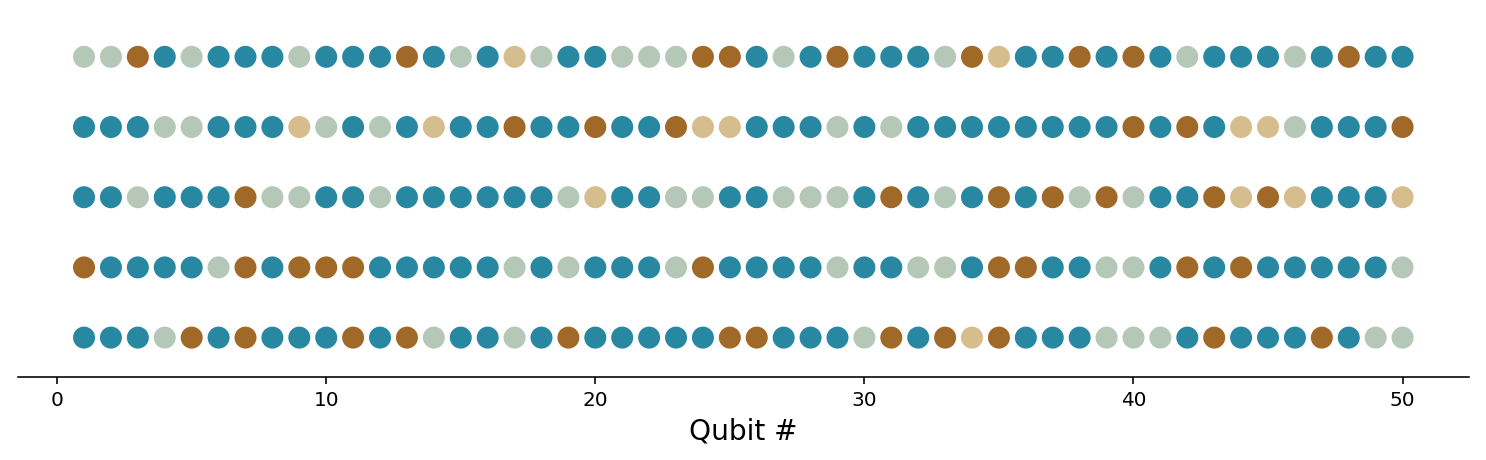

In [20]:
def plot_samples(sample_test = samples, n_samples = 1, n_qubits = n_qubits, batchSize=batchSize):
    
    if n_samples > batchSize:
        print("Number of samples must be less than batchSize.")
        return -1
        
    qubits = np.arange(1, n_qubits + 1)
    rand_idx = torch.randperm(n_samples)
    color_labels = samples[rand_idx]
    #print(color_labels[0].shape, qubits.shape)
    #UnlabelledY=[0,1,0]
    fig = plt.figure(figsize=(15,1))
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    muted=["#4878CF", "#6ACC65", "#D65F5F",
               "#B47CC7", "#C4AD66", "#77BEDB"]
    #my_cmap = ListedColormap(sns.color_palette(muted).as_hex())
    #cmap = sns.cubehelix_palette(light=0.8, dark=0.4, start=0.03, rot=0.4, as_cmap=True)
    cmap = ListedColormap(palettable.cartocolors.diverging.Earth_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Chevalier_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Darjeeling2_5.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Moonrise2_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.FantasticFox2_5.mpl_colors)
    print(cmap)
    
    if n_samples == 1:
        fig = plt.figure(figsize=(15,1))
        plt.scatter(qubits, np.zeros_like(qubits), 
                c=color_labels[0], cmap=cmap, vmin=0, s=120)
        #plt.axis('off')
        plt.xlabel("Qubit #", fontsize=14)
    else:
        fig, axes = plt.subplots(n_samples, 1, figsize=(13,n_samples * 0.66))
        fig.subplots_adjust(hspace=-0.1)
        for i in range(n_samples):
            axes[i].scatter(qubits, np.zeros_like(qubits), 
                    c=color_labels[i], cmap=cmap, vmin=0, s=100)
            axes[i].set_yticks([])
            sns.despine(left=True, bottom=True)
            #sns.despine(bottom=True)
            #sns.despine(top=True)
            if i == n_samples - 1:
                axes[i].set_xlabel("Qubit #", fontsize=14)
                axes[i].spines["bottom"].set_visible(True)
            else:
                axes[i].set_xticks([])

    plt.show()
    return

plot_samples(sample_test = samples, n_samples = 5, n_qubits = 50)


In [14]:
from torch import optim
from pepinillo.dataloader import POVMData
from pepinillo.operators import Pauli4, Pauli
import _pickle as pkl


povm = Pauli4()
dataset = POVMData('../notebooks/data/TFIM_training_data.npz', povm)
dataset = POVMData(dataset.filename, dataset.povm_set, data=dataset.data[:20000])


In [15]:
dataset.data[0,:,:].shape

torch.Size([50, 4])

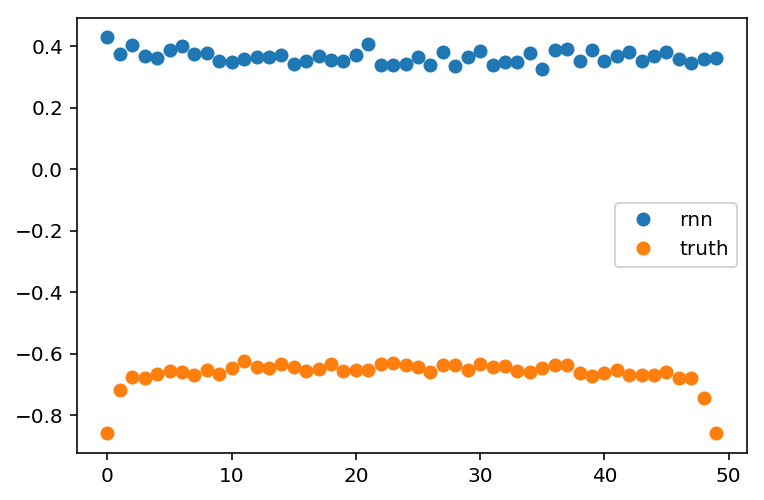

In [37]:
#samples = torch.cat([model.sample() for i in range(200)], dim=1) 
samples = generate(rnn, batch_size = 20000)
#samples = samples.permute([1, 0, 2])
idsamples = np.zeros((20000, n_qubits), dtype=np.long)
idsamples2 = np.zeros((20000, n_qubits), dtype=np.long)

for i in range(20000):
    idsamples[i, :] = samples[i]
    idsamples2[i, :] = np.argmax(dataset.data[i, :, :], axis=1)
    

measure_X = [povm.rho(idsamples).measure(Pauli.X).on(i) for i in range(n_qubits)]
measure_X2 = [povm.rho(idsamples2).measure(Pauli.X).on(i) for i in range(n_qubits)]

import matplotlib.pyplot as plt

plt.plot(measure_X,  'o', label='rnn',)
plt.plot(measure_X2, 'o', label='truth', )
plt.legend()